# Preparations

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
from unidecode import unidecode
from wordcloud import WordCloud
import re
from string import punctuation
import nltk
nltk.download('punkt')
from nltk import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gulyagurbanova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Function to deal with dates with multiple formats
def parse_date(date_str):
    formats = ['%d/%m/%Y', '%Y-%m-%d']
    for fmt in formats:
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            continue
    return pd.NaT  # Return NaT if none of the formats match

# Reading the original CSV file
df = pd.read_csv('/Users/gulyagurbanova/Desktop/uom/extended research/data/detailed review data.csv')

# Applying the date parsing function to the 'date' column
df['date'] = df['date'].apply(parse_date)

# Defining the date range (3 years time)
start_date = pd.to_datetime('22/03/2021', format='%d/%m/%Y')
end_date = pd.to_datetime('22/03/2024', format='%d/%m/%Y')

# Filtering the DataFrame for dates within the specified range
filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)].copy()

# Converting dates back to the desired format
filtered_df.loc[:, 'date'] = filtered_df['date'].dt.strftime('%d/%m/%Y')

# Saving the filtered DataFrame to a new CSV file with gzip compression
filtered_df.to_csv('/Users/gulyagurbanova/Desktop/uom/extended research/data/filtered_file.csv.gz', index=False, compression='gzip', encoding='utf-8')
print('Filtered CSV file has been saved successfully.')

# Reading the filtered CSV file with the specified additions
df = pd.read_csv('/Users/gulyagurbanova/Desktop/uom/extended research/data/filtered_file.csv.gz', compression='gzip', encoding='utf-8', low_memory=False)

print('Filtered CSV file has been read successfully.')

Filtered CSV file has been saved successfully.
Filtered CSV file has been read successfully.


In [5]:
# Data types
df.dtypes

listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object

# View Your Dataset

In [6]:
# Review dataset top rows
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,15420,755523548,2021-06-05,187504576,Pascale,A fantastic apartment which is beautifully fur...
1,15420,761386255,2021-05-23,119596131,Megan,We had the most amazing stay at Charlotte's pl...
2,15420,770467244,2021-06-14,111721539,Julian,I booked Charlotte's apartment as a surprise f...
3,15420,396926559045081909,2021-01-07,41684971,Louise,I've stayed at Charlotte's place many times. S...
4,15420,398989660111676009,2021-04-07,357578834,Hilary,Such a fabulous apartment in a brilliant locat...


In [7]:
# Review dataset last rows
df.tail()

,listing_id,id,date,reviewer_id,reviewer_name,comments
266424,1105090362934985066,1114376165154994462,2024-03-17,438400469,Anup,Had wonderful time over there.
266425,1106309197963852421,1111502232312727722,2024-03-13,483439174,Yat Long,Spacious and cozy apartment with two bedrooms ...
266426,1107704542773356229,1113693876340184126,2024-03-16,94224388,Ana,"Lovely stay, great location and very helpful. ..."
266427,1111484428234063489,1114383629151965699,2024-03-17,506530479,Sarah,very good at communicating and fast booking gr...
266428,1113759691139175992,1118048048281146149,2024-03-22,193425070,Anthony,Nice place in a great location


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266429 entries, 0 to 266428
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     266429 non-null  int64 
 1   id             266429 non-null  int64 
 2   date           266429 non-null  object
 3   reviewer_id    266429 non-null  int64 
 4   reviewer_name  266429 non-null  object
 5   comments       266401 non-null  object
dtypes: int64(3), object(3)
memory usage: 12.2+ MB


In [9]:
# Check the number of rows in the new CSV
num_rows = df.shape[0]
print(f'The filtered CSV file has {num_rows} rows.')

The filtered CSV file has 266429 rows.


# Data Cleaning

In [3]:
# Dropping missing values
df.dropna(inplace=True)

In [4]:
num_rows = df.shape[0]
print(f'The filtered CSV file after dropping missing values has {num_rows} rows.')

The filtered CSV file after dropping missing values has 266401 rows.


In [5]:
# Reviewer name is not necessary for the analysis
df.drop(columns={'reviewer_name'}, inplace=True)
df.head(10)

,listing_id,id,date,reviewer_id,comments
0,15420,7.555235e+08,2021-06-05,187504576.0,A fantastic apartment which is beautifully fur...
1,15420,7.613863e+08,2021-05-23,119596131.0,We had the most amazing stay at Charlotte's pl...
2,15420,7.704672e+08,2021-06-14,111721539.0,I booked Charlotte's apartment as a surprise f...
3,15420,3.969266e+17,2021-01-07,41684971.0,I've stayed at Charlotte's place many times. S...
4,15420,3.989897e+17,2021-04-07,357578834.0,Such a fabulous apartment in a brilliant locat...
5,15420,4.084697e+17,2021-07-17,287544117.0,The photos do not do this beautiful Georgian h...
6,15420,4.128698e+17,2021-07-23,82780677.0,Amazing apartment and Charlotte was super help...
7,15420,4.200175e+17,2021-02-08,362544076.0,"Great location, comfortable and full of charac..."
8,15420,4.251253e+17,2021-09-08,106192052.0,Sometimes AirBnB can be deceiving. Every place...
9,15420,4.309408e+17,2021-08-17,66379176.0,"This place is fantastic. Good location, lovely..."


/Users/gulyagurbanova/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


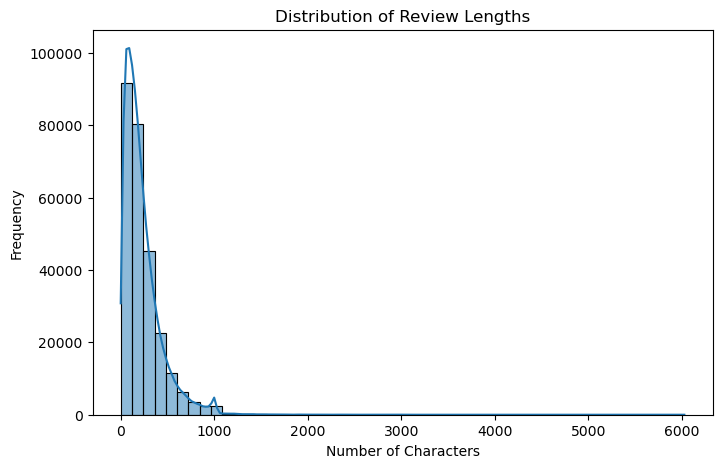

In [6]:
# EDA
# Calculate the length of each review
df['Number of Characters'] = df['comments'].apply(len)

# Plot the distribution of review lengths
plt.figure(figsize = (8,5))
sns.histplot(data = df, x = 'Number of Characters', bins = 50, kde = True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

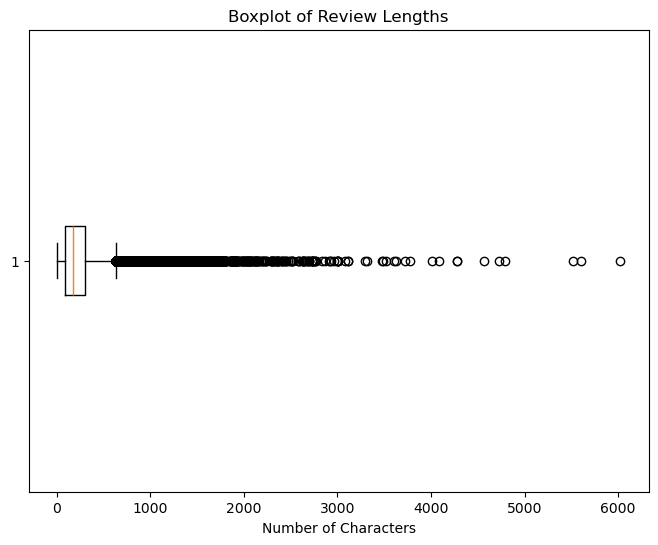

In [14]:
# Plot a boxplot of the review lengths
plt.figure(figsize=(8, 6))
plt.boxplot(df['Number of Characters'], vert=False)
plt.title('Boxplot of Review Lengths')
plt.xlabel('Number of Characters')
plt.show()

In [7]:
# Calculate the 1st quartile (25th percentile) of the review lengths
first_quartile = df['Number of Characters'].quantile(0.25)
print(f"1st Quartile of review lengths: {first_quartile}")

# Inspect the summary statistics
print(df['Number of Characters'].describe())

1st Quartile of review lengths: 91.0
count    266401.000000
mean        232.421233
std         209.115113
min           1.000000
25%          91.000000
50%         177.000000
75%         307.000000
max        6025.000000
Name: Number of Characters, dtype: float64


In [10]:
# Filter the DataFrame to get reviews shorter than the 1st quartile
short_reviews = df[df['Number of Characters'] < first_quartile]

# Display the first few reviews that are shorter than the 1st quartile
print("Reviews shorter than the 1st quartile:")
print(short_reviews[['comments', 'Number of Characters']].head(20))

Reviews shorter than the 1st quartile:
                                              comments  Number of Characters
15   Great location if traveling by train, really h...                    66
27   Fantastic apartment fantastic location fantast...                    53
43   Fantastic flat with all the comforts situated ...                    88
44   Exceptional place, great communication and so ...                    83
50   This apartment was a delight to stay in and wa...                    72
58                Fabulous Airbnb! I would recommend!!                    36
62   Great location great place to stay and the bes...                    75
105  Väldigt bra värd inga problem med någonting, g...                    89
108                      Good location and fair price.                    29
111  Fabulous flat, great location, very clear and ...                    77
113  this place was perfect, absolutely beautiful a...                    81
114  What a wonderful find! Amazing A

In [16]:
# Filter out reviews that are shorter than the 1st quartile length
df = df[df['Number of Characters'] >= first_quartile]

# Check the shape of the DataFrame after filtering
print(f"Filtered DataFrame shape: {df.shape}")

Filtered DataFrame shape: (200593, 6)


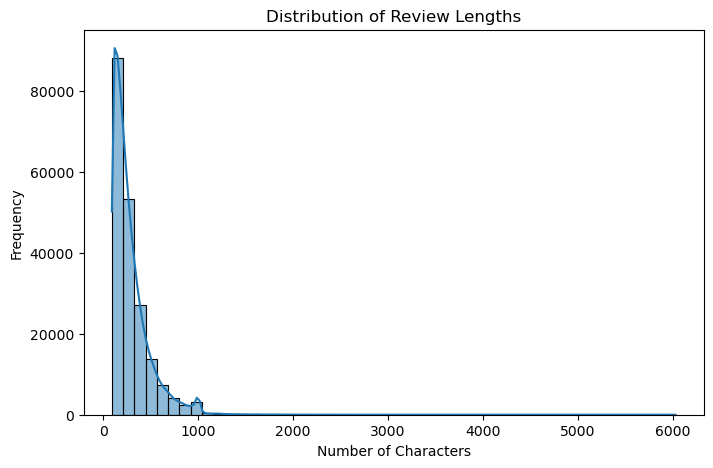

In [17]:
# Plot the distribution of review lengths
plt.figure(figsize = (8,5))
sns.histplot(data = df, x = 'Number of Characters', bins = 50, kde = True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

In [18]:
# Distribution of Reviews per year
df['Year']= pd.DatetimeIndex(df['date']).year
ReviewDistributionDF=df.groupby(['Year']).comments.count().reset_index()
ReviewDistributionDF

,Year,comments
0,2021,27996
1,2022,65340
2,2023,94474
3,2024,12783


# Language Detection

In [21]:
# Directly identify the language of the reviews - runtime 10 and 17 mins on colab - vscode 4 mins
df['Lang'] = df['comments'].apply(detect)

# Generate a distribution of the detected languages
LangDistributionDF = df.groupby(['Lang']).Lang.count()

# Display the language distribution
print(LangDistributionDF)

Lang
af            4
ar           36
bg            7
ca           91
cs           87
cy            1
da          290
de         4207
el           39
en       177517
es         4492
et            1
fi           27
fr         8453
he           18
hr            4
hu           27
id            1
it         1499
ja           40
ko          333
lt            7
lv            6
nl         1436
no          157
pl          210
pt          734
ro           16
ru           48
sk           27
sl            8
sv          193
th            2
tr           61
uk           14
vi            2
zh-cn       479
zh-tw        19
Name: Lang, dtype: int64


In [22]:
# Distribution of languages
LangYearDistribution1=pd.DataFrame(df.groupby(['Year','Lang']).comments.count())
Lang_Year_tableDF = pd.pivot_table(LangYearDistribution1, values='comments', index=['Year'],columns=['Lang'])
Lang_Year_tableDF

Lang,af,ar,bg,ca,cs,cy,da,de,el,en,...,ru,sk,sl,sv,th,tr,uk,vi,zh-cn,zh-tw
Year,,,,,,,,,,,,,,,,,,,,,
2021,NaN,NaN,NaN,4.0,2.0,NaN,2.0,37.0,1.0,27624.0,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN
2022,NaN,3.0,1.0,20.0,13.0,1.0,51.0,975.0,6.0,59924.0,...,9.0,1.0,NaN,26.0,1.0,5.0,2.0,NaN,61.0,2.0
2023,4.0,29.0,4.0,55.0,58.0,NaN,225.0,2928.0,21.0,79566.0,...,33.0,21.0,7.0,155.0,1.0,49.0,11.0,2.0,334.0,15.0
2024,NaN,4.0,2.0,12.0,14.0,NaN,12.0,267.0,11.0,10403.0,...,3.0,5.0,1.0,12.0,NaN,7.0,1.0,NaN,64.0,2.0


In [23]:
# Selecting only english reviews
df=df[df['Lang']=='en']
df.head()

,listing_id,id,date,reviewer_id,comments,ReviewLenght,Year,Lang
0,15420,755523548,2021-06-05,187504576,A fantastic apartment which is beautifully fur...,325,2021,en
1,15420,761386255,2021-05-23,119596131,We had the most amazing stay at Charlotte's pl...,332,2021,en
2,15420,770467244,2021-06-14,111721539,I booked Charlotte's apartment as a surprise f...,450,2021,en
3,15420,396926559045081909,2021-01-07,41684971,I've stayed at Charlotte's place many times. S...,206,2021,en
4,15420,398989660111676009,2021-04-07,357578834,Such a fabulous apartment in a brilliant locat...,112,2021,en


In [24]:
num_rows = df.shape[0]
print(f'After language detection CSV file has {num_rows} rows.')

After language detection CSV file has 177517 rows.


In [27]:
# Handling Special Characters - Convert all non-ASCII characters to ASCII in the 'comments' column
df['comments'] = df['comments'].apply(lambda x: unidecode(x) if isinstance(x, str) else x)

In [28]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 177517 entries, 0 to 266427
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   listing_id    177517 non-null  int64 
 1   id            177517 non-null  int64 
 2   date          177517 non-null  object
 3   reviewer_id   177517 non-null  int64 
 4   comments      177517 non-null  object
 5   ReviewLenght  177517 non-null  int64 
 6   Year          177517 non-null  int32 
 7   Lang          177517 non-null  object
dtypes: int32(1), int64(4), object(3)
memory usage: 11.5+ MB


In [10]:
# Getting the name of host in front of each review
list_df = pd.read_csv('/Users/gulyagurbanova/Desktop/uom/extended research/data/detailed listings data.csv')

In [11]:
list_df.rename(columns={'id':'listing_id'}, inplace= True)

In [12]:
# Converting listing_id to string type in both DataFrames
df['listing_id'] = df['listing_id'].astype(str)
list_df['listing_id'] = list_df['listing_id'].astype(str)

In [32]:
df.info()
list_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177517 entries, 0 to 266427
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   listing_id    177517 non-null  object
 1   id            177517 non-null  int64 
 2   date          177517 non-null  object
 3   reviewer_id   177517 non-null  int64 
 4   comments      177517 non-null  object
 5   ReviewLenght  177517 non-null  int64 
 6   Year          177517 non-null  int32 
 7   Lang          177517 non-null  object
dtypes: int32(1), int64(3), object(4)
memory usage: 11.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4812 entries, 0 to 4811
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   listing_id                                    4812 non-null   object 
 1   listing_url                                   4812 non-null   objec

In [13]:
df=df.merge(list_df[['listing_id','host_name','neighbourhood_cleansed','room_type','price','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']], on='listing_id', how= 'inner')

In [34]:
df.head()

,listing_id,id,date,reviewer_id,comments,ReviewLenght,Year,Lang,host_name,neighbourhood_cleansed,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,15420,755523548,2021-06-05,187504576,A fantastic apartment which is beautifully fur...,325,2021,en,Charlotte,"Old Town, Princes Street and Leith Street",Entire home/apt,$120.00,3,545,3.4,1,58
1,15420,761386255,2021-05-23,119596131,We had the most amazing stay at Charlotte's pl...,332,2021,en,Charlotte,"Old Town, Princes Street and Leith Street",Entire home/apt,$120.00,3,545,3.4,1,58
2,15420,770467244,2021-06-14,111721539,I booked Charlotte's apartment as a surprise f...,450,2021,en,Charlotte,"Old Town, Princes Street and Leith Street",Entire home/apt,$120.00,3,545,3.4,1,58
3,15420,396926559045081909,2021-01-07,41684971,I've stayed at Charlotte's place many times. S...,206,2021,en,Charlotte,"Old Town, Princes Street and Leith Street",Entire home/apt,$120.00,3,545,3.4,1,58
4,15420,398989660111676009,2021-04-07,357578834,Such a fabulous apartment in a brilliant locat...,112,2021,en,Charlotte,"Old Town, Princes Street and Leith Street",Entire home/apt,$120.00,3,545,3.4,1,58


In [35]:
df.dtypes

listing_id                         object
id                                  int64
date                               object
reviewer_id                         int64
comments                           object
ReviewLenght                        int64
Year                                int32
Lang                               object
host_name                          object
neighbourhood_cleansed             object
room_type                          object
price                              object
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [3]:
# Calculate the number of unique listings in the DataFrame
unique_listings = df['listing_id'].nunique()

# Display the number of unique listings
print(f"Number of unique listings: {unique_listings}")

Number of unique listings: 4261


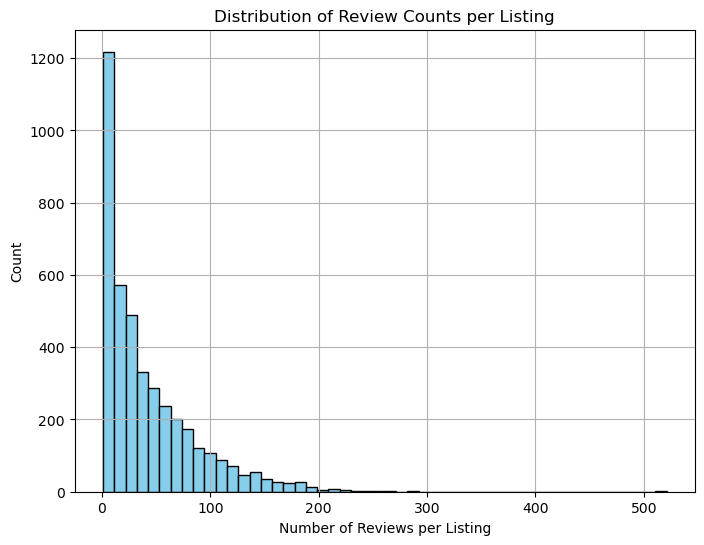

In [37]:
# Calculate the number of reviews per listing
reviews_per_listing = df.groupby('listing_id').size().reset_index(name='review_count')

# Plot the distribution of review counts per listing. The graph is designed to show the distribution of review counts across all listings, not individual listing IDs.
plt.figure(figsize=(8, 6))
plt.hist(reviews_per_listing['review_count'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Counts per Listing')
plt.xlabel('Number of Reviews per Listing')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [38]:
# Calculate the number of reviews per listing
reviews_per_listing = df.groupby('listing_id').size().reset_index(name='review_count')

# Merge the review counts back into the original DataFrame
df_with_counts = df.merge(reviews_per_listing, on='listing_id')

# Create DataFrame for listings with fewer than 5 reviews
df_few_reviews = df_with_counts[df_with_counts['review_count'] < 3]

# Create DataFrame for listings with more than 5 reviews
df_many_reviews = df_with_counts[df_with_counts['review_count'] > 3]

# Display the number of listings in each group
print(f"Listings with fewer than 5 reviews: {df_few_reviews['listing_id'].nunique()}")
print(f"Listings with more than 5 reviews: {df_many_reviews['listing_id'].nunique()}")

Listings with fewer than 5 reviews: 359
Listings with more than 5 reviews: 3673


In [39]:
# Set a seed for reproducibility
np.random.seed(42)

# Sample 10 reviews from each group
sample_few_reviews = df_few_reviews.sample(n=10, random_state=42)
sample_many_reviews = df_many_reviews.sample(n=10, random_state=42)

# Display the samples
print("Sample of reviews from listings with fewer than 5 reviews:")
print(sample_few_reviews[['listing_id', 'comments']])

print("\nSample of reviews from listings with more than 5 reviews:")
print(sample_many_reviews[['listing_id', 'comments']])

Sample of reviews from listings with fewer than 5 reviews:
                 listing_id                                           comments
172687   901433956752461315  I stayed for 2 nights in this apartment.<br/>T...
177492  1087712368391572360  Great value for a modern and clean house in a ...
177236  1025919914991343639  Served our purpose of a bed for the night in E...
139511             53181604  Our stay at the 'Balerno Inn' was fabulous. Co...
177494  1089989375491063296  The room felt very clean and warm, and the lan...
121834             46965090  Great stay! The property is located close to t...
161599   681323219500853046  Perfectly located apartment. Brandon  was very...
177512  1099245562738502645  Had a great stay! Location was really handy fo...
173745   918709234913675511  Great place and location. Perfect for explorin...
169446   813312630241422986  John is a very friendly and responsive host. B...

Sample of reviews from listings with more than 5 reviews:
             

# Removing Numbers, Lowecasing and Host Adjustment

In [41]:
# Function to remove numbers from a string
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Apply the function to the 'comments' column
df['comments'] = df['comments'].apply(remove_numbers)

# Check the first few rows to ensure the numbers were removed
print(df['comments'].head())

0    A fantastic apartment which is beautifully fur...
1    We had the most amazing stay at Charlotte's pl...
2    I booked Charlotte's apartment as a surprise f...
3    I've stayed at Charlotte's place many times. S...
4    Such a fabulous apartment in a brilliant locat...
Name: comments, dtype: object


In [42]:
num_rows = df.shape[0]
print(f'After number removal CSV file has {num_rows} rows.')

After number removal CSV file has 177517 rows.


In [43]:
# Converting text to lowercase to ensure consistency, reduction of redundancy and improved matching
df['comments']=df['comments'].str.lower()
df['host_name']=df['host_name'].str.lower()

In [44]:
# Fixing errors with apostrophes
df["comments"] = df["comments"].str.replace(" '","'", regex = False)
df["comments"] = df["comments"].str.replace("' s","'s", regex =False)

In [45]:
# Aligning 'and's
df['host_name']=df['host_name'].str.replace("&","and")
df['host_name']=df['host_name'].str.replace("+","and")

In [46]:
test=df[df['host_name'].str.contains(" and ")]
test.head()

,listing_id,id,date,reviewer_id,comments,ReviewLenght,Year,Lang,host_name,neighbourhood_cleansed,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
2205,500696,754580711,2021-03-05,228845116,fabulous location <br/>friendly host <br/>nice...,92,2021,en,sue and grant,Tollcross,Entire home/apt,$90.00,3,370,2.57,14,18
2206,500696,759844708,2021-05-18,395797725,beautiful flat in a simply incredible location...,185,2021,en,sue and grant,Tollcross,Entire home/apt,$90.00,3,370,2.57,14,18
2207,500696,769807978,2021-06-13,79648240,susan was really helpful and everything went v...,129,2021,en,sue and grant,Tollcross,Entire home/apt,$90.00,3,370,2.57,14,18
2208,500696,394738810141138030,2021-06-28,119785925,the flat is perfectly located for exploring ed...,135,2021,en,sue and grant,Tollcross,Entire home/apt,$90.00,3,370,2.57,14,18
2209,500696,401254425932976386,2021-07-07,357848890,a perfect flat with all the home comforts in a...,100,2021,en,sue and grant,Tollcross,Entire home/apt,$90.00,3,370,2.57,14,18


In [47]:
# Removing records where host name is more than one to ensure matching host names in reviews and simplified analysis
df = df.drop(df[df['host_name'].str.contains(" and ")].index)

In [48]:
num_rows = df.shape[0]
print(f'After 2 host names are removed CSV file has {num_rows} rows.')

After 2 host names are removed CSV file has 167567 rows.


In [49]:
df['ReviewLenght']=df['comments'].apply(lambda x: len(x))

# Tokenization

In [14]:
# Adding new columns (per review) useful for text mining and NLP
df['Number of Sentences']=df['comments'].apply(lambda x: len(nltk.tokenize.sent_tokenize(x)))
df['Number of Words']= df['comments'].apply(lambda x: len(x.split()))
df['Number of Characters']=df['comments'].str.len()

# Anonymisation

In [51]:
# Replacing the name of the host with 'host' for anonymization purposes and improved text analysis
def replace(str1, str2):
    return re.sub(str2, 'host', str1)

df['comments'] = df.apply(lambda row: replace(row['comments'], row['host_name']), axis=1)

In [52]:
def replace_with_host(comment, host_name):
    comment = re.sub(host_name, 'host', comment, flags=re.IGNORECASE)
    pronouns = ['he', 'she', 'him', 'her', 'his', 'hers', 'they', 'them', 'their', 'theirs', 'person', 'people', 'lady', 'hosts', 'household','communicator','campanion','hospitality','landlord']
    for pronoun in pronouns:
        comment = re.sub(r'\b' + pronoun + r'\b', 'host', comment, flags=re.IGNORECASE)
    return comment

df['comments'] = df.apply(lambda row: replace_with_host(row['comments'], row['host_name']), axis=1)

In [53]:
# Create a dictionary to map host names to unique identifiers
host_name_to_id = {name: f'host_{i}' for i, name in enumerate(df['host_name'].unique())}

# Replace host names with unique identifiers
df['host_name'] = df['host_name'].map(host_name_to_id)

# Verify the changes
print(df['host_name'].head())

0    host_0
1    host_0
2    host_0
3    host_0
4    host_0
Name: host_name, dtype: object


# Fixing Typos

In [54]:
# Function to clean HTML tags and extra spaces
def clean_html_tags(text):
    # Remove all HTML tags
    clean_text = re.sub(r'<.*?>', ' ', text)
    # Remove any extra spaces left after removing tags
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()
    return clean_text

# Apply the function to the comments column
df['comments'] = df['comments'].apply(clean_html_tags)

In [55]:
# Dictionary of replacements (errors, typos)
replacements = {
    r'\bcomfy\b': 'comfortable',
    r'\bapartments\b': 'apartment',
    r'\bairbnbs\b': 'airbnb',
    r'\bflat\b': 'apartment',
    r'\bhouse\b': 'house',
    r'\bhost place\b': 'airbnb',
    r'\bair bnb\b': 'airbnb',
    r'\bairb&b\b': 'airbnb',
    r'\bgarden home\b': 'house',
    r'\ben suite\b': 'en-suite',
    r'\b ensuite\b': 'en-suite',
    r'\bcity centre\b': 'city-centre',
    r'\bcity center\b': 'city-centre',
    r'\btown centre\b': 'town-centre',
    r'\btown center\b': 'town-centre',
    r'\baccomodating\b': 'accommodating',
    r'\bamazig\b': 'amazing',
    r'\bamazng\b': 'amazing',
    r'\bavaiable\b': 'available',
    r'\bwelcomming\b': 'welcoming',
    r'\bwondeful\b': 'wonderful',
    r'\bwounderful\b': 'wonderful',
    r'\bknowledgable\b': 'knowledgeable',
    r'\bv, helpful\b': 'helpful',
    r'\bquick, responding\b': 'responding',
    r'\bconfortable\b': 'comfortable',
    r'\bcomfotable\b': 'comfortable',
    r'\bfab\b': 'fabulous',
    r'\bcomfortable, sitting\b': 'comfortable',
    r'\bextra, comfortable\b': 'comfortable',
    r'\blovey\b': 'lovely',
    r'\bbeatiful\b': 'beautiful',
    r'\bbeautifull\b': 'beautiful',
    r'\bicnredible\b': 'incredible',
    r'\bhelful\b': 'helpful',
    r'\bgraet\b': 'great',
    r'\bextreme, responsive\b': 'responsive',
    r'\bking, comfortable\b': 'comfortable',
    r'\bnice, stylish\b': 'stylish',
    r'\bairbnb home\b': 'home',
    r'\brecomend\b': 'recommend',
    r'\brecomendable\b': 'recommendable',
    r'\brecomended\b': 'recommended',
    r'\bdeff\b': 'definitely',
    r'\bdef\b': 'definitely',
    r'\bu\b': 'you',
    r'\blivingroom\b': 'living room',
    r'\bcomfiest\b': 'most comfortable',
    r'\bdin room\b': 'dining room',
    r'\bdefinately\b': 'definitely',
    r'\b(?:jack|craig|fiona|wendy|vixy|kate|jessica|anna|louise|andrew|josef|nicole|challote|matty|marius)\b(?:\'s)?': 'host',
    r'\buber\b': 'taxi',
    r'\bubers\b': 'taxi',
    r':\)': 'happy',
    r'\bxx\b': '',
    r'\bair bandb\b': 'airbnb',
    r'\bair bnbs\b': 'airbnb',
    r'\bbnb\b': 'airbnb',
    r'\btiddy\b': 'tidy',
    r'\bca\s+n\'t\b': "can't"
}

# Apply replacements
for pattern, replacement in replacements.items():
    df['comments']=df['comments'].str.replace(pattern, replacement, regex=True)

# Additional replacement for '&' to 'and'
df['comments'] = df['comments'].str.replace("&", "and")

In [57]:
# Column = if 'host' is mentioned in the review
df['Host']=df['comments'].str.contains("host")

In [58]:
df['Host freq']=list(map(lambda x: x.count('host'), df['comments']))

In [59]:
df['Host freq'].describe()

count    167567.000000
mean          1.295452
std           1.577246
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          88.000000
Name: Host freq, dtype: float64

In [60]:
df.head()

,listing_id,id,date,reviewer_id,comments,ReviewLenght,Year,Lang,host_name,neighbourhood_cleansed,...,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Number of Sentences,Number of Words,Number of Characters,Host,Host freq
0,15420,755523548,2021-06-05,187504576,a fantastic apartment which is beautifully fur...,324,2021,en,host_0,"Old Town, Princes Street and Leith Street",...,3,545,3.4,1,58,3,50,324,False,0
1,15420,761386255,2021-05-23,119596131,we had the most amazing stay at host's place. ...,332,2021,en,host_0,"Old Town, Princes Street and Leith Street",...,3,545,3.4,1,58,6,54,332,True,2
2,15420,770467244,2021-06-14,111721539,i booked host's apartment as a surprise for my...,450,2021,en,host_0,"Old Town, Princes Street and Leith Street",...,3,545,3.4,1,58,6,78,450,True,3
3,15420,396926559045081909,2021-01-07,41684971,i've stayed at host's place many times. so com...,206,2021,en,host_0,"Old Town, Princes Street and Leith Street",...,3,545,3.4,1,58,3,33,206,True,2
4,15420,398989660111676009,2021-04-07,357578834,such a fabulous apartment in a brilliant locat...,112,2021,en,host_0,"Old Town, Princes Street and Leith Street",...,3,545,3.4,1,58,2,19,112,True,1


# Saving New DF

In [61]:
df.shape[0]

167567

In [76]:
df.to_csv('/Users/gulyagurbanova/Desktop/uom/extended research/data/processed_reviews_first.csv', index=False)

print('Final preprocessed DataFrame has been save to data folder')

Final preprocessed DataFrame has been save to data folder


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167567 entries, 0 to 177516
Data columns (total 22 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   listing_id                      167567 non-null  object 
 1   id                              167567 non-null  int64  
 2   date                            167567 non-null  object 
 3   reviewer_id                     167567 non-null  int64  
 4   comments                        167567 non-null  object 
 5   ReviewLenght                    167567 non-null  int64  
 6   Year                            167567 non-null  int32  
 7   Lang                            167567 non-null  object 
 8   host_name                       167567 non-null  object 
 9   neighbourhood_cleansed          167567 non-null  object 
 10  room_type                       167567 non-null  object 
 11  price                           167567 non-null  object 
 12  minimum_nights       

# Initial Visualisations

In [64]:
# Overall count of listings
total_listings = df['listing_id'].nunique()
print(f'Total number of unique listings: {total_listings}')

Total number of unique listings: 3993


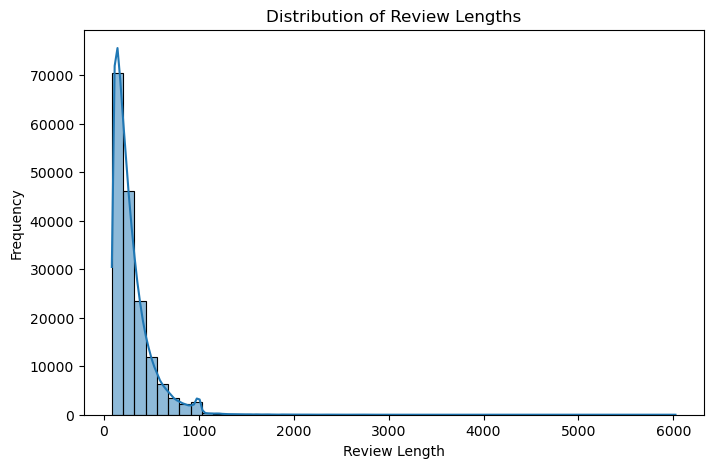

In [65]:
# Plotting distribution of Review Lengths - gauging the typical lentgh of reviews and identify outliers
plt.figure(figsize = (8,5))
sns.histplot(data = df, x = 'ReviewLenght', bins = 50, kde = True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

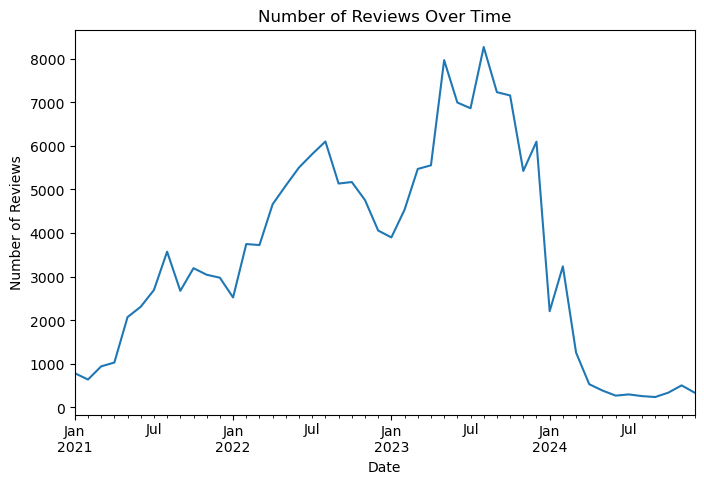

In [66]:
# Monitoring the number of reviews over time (per month) - can reveal trends and seasonal patterns in customer feedback
df['date'] = pd.to_datetime(df['date'])
reviews_over_time = df.groupby(df['date'].dt.to_period('M')).size()

plt.figure(figsize=(8,5))
reviews_over_time.plot(kind='line')
plt.title('Number of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()

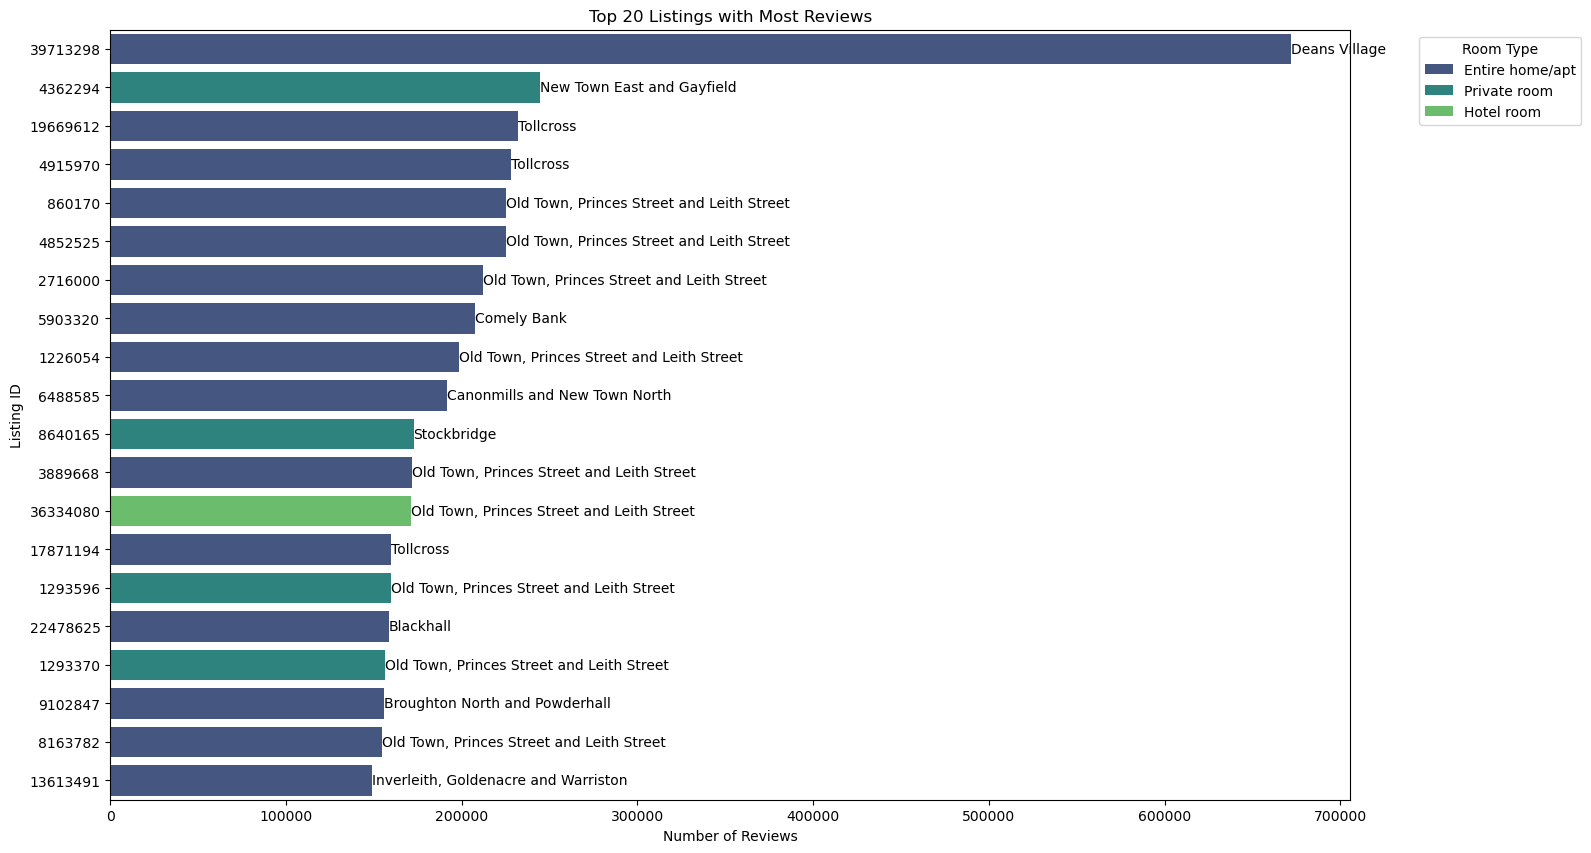

In [67]:
# Top 20 listings with the most reviews

# Ensure the number_of_reviews column is of integer type
df['number_of_reviews'] = df['number_of_reviews'].astype(int)

# Group by listing_id and sum the number of reviews for each listing
top_20_reviews = df.groupby('listing_id')['number_of_reviews'].sum().nlargest(20).reset_index()

# Merge with original DataFrame to get room_type and neighborhood
top_20_reviews = top_20_reviews.merge(df[['listing_id', 'room_type', 'neighbourhood_cleansed']].drop_duplicates(), on='listing_id', how='left')

plt.figure(figsize=(16, 10))
sns.barplot(x='number_of_reviews', y='listing_id', data=top_20_reviews, hue='room_type', dodge=False, palette='viridis')

# Adding text annotations for neighbourhoods
for index, row in top_20_reviews.iterrows():
  plt.text(row.number_of_reviews, index, row.neighbourhood_cleansed, color='black', ha='left', va='center')

plt.title('Top 20 Listings with Most Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Listing ID')
plt.legend(title='Room Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

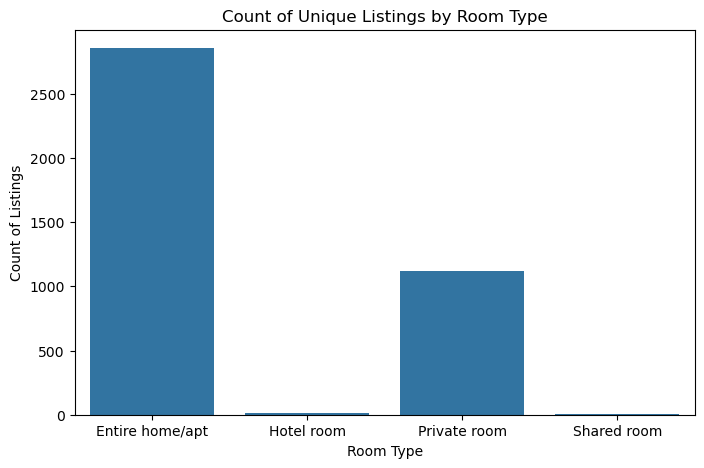

In [68]:
# Plotting the count of listings by room type
unique_listings_by_room_type = df.groupby('room_type')['listing_id'].nunique().reset_index()
unique_listings_by_room_type = unique_listings_by_room_type.rename(columns={'listing_id':'unique_listings'})

plt.figure(figsize = (8,5))
sns.barplot(data=unique_listings_by_room_type, x='room_type', y='unique_listings')
plt.title('Count of Unique Listings by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Count of Listings')
plt.show()

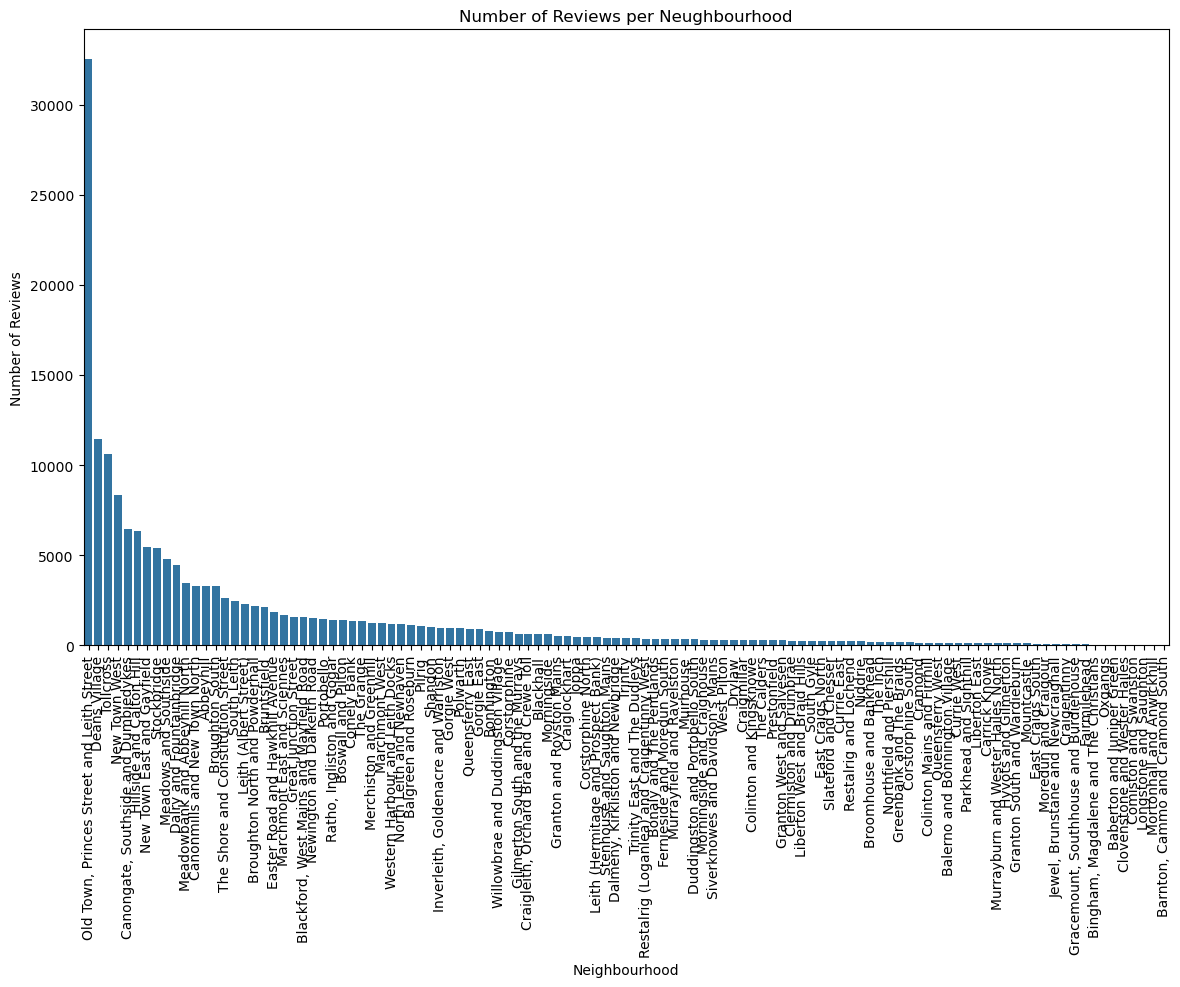

In [69]:
# Most popular neighbourhoods
plt.figure(figsize = (14,8))
sns.countplot(data=df, x='neighbourhood_cleansed', order = df['neighbourhood_cleansed'].value_counts().index)
plt.title('Number of Reviews per Neughbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=90)
plt.show()

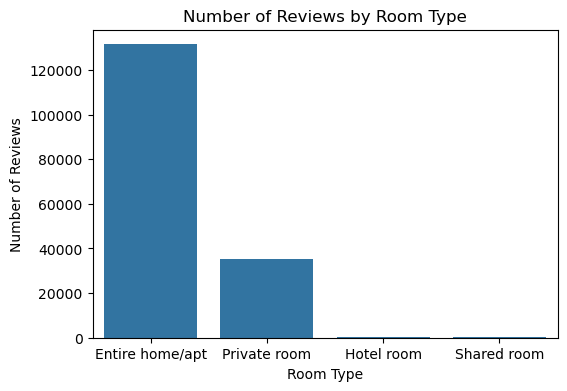

In [70]:
# Reviews by room type - reflect customer preferences for different types of accommodations
plt.figure(figsize = (6,4))
sns.countplot(data=df, x='room_type')
plt.title('Number of Reviews by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Number of Reviews')
plt.show()

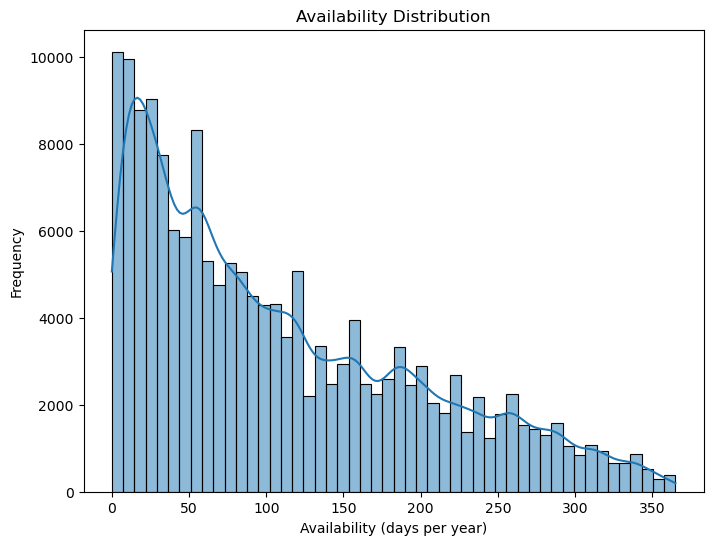

In [71]:
# Availability Distribution - to understand booking patterns and how frequently listings are available
plt.figure(figsize=(8,6))
sns.histplot(data=df, x='availability_365', bins=50, kde=True)
plt.title('Availability Distribution')
plt.xlabel('Availability (days per year)')
plt.ylabel('Frequency')
plt.show()

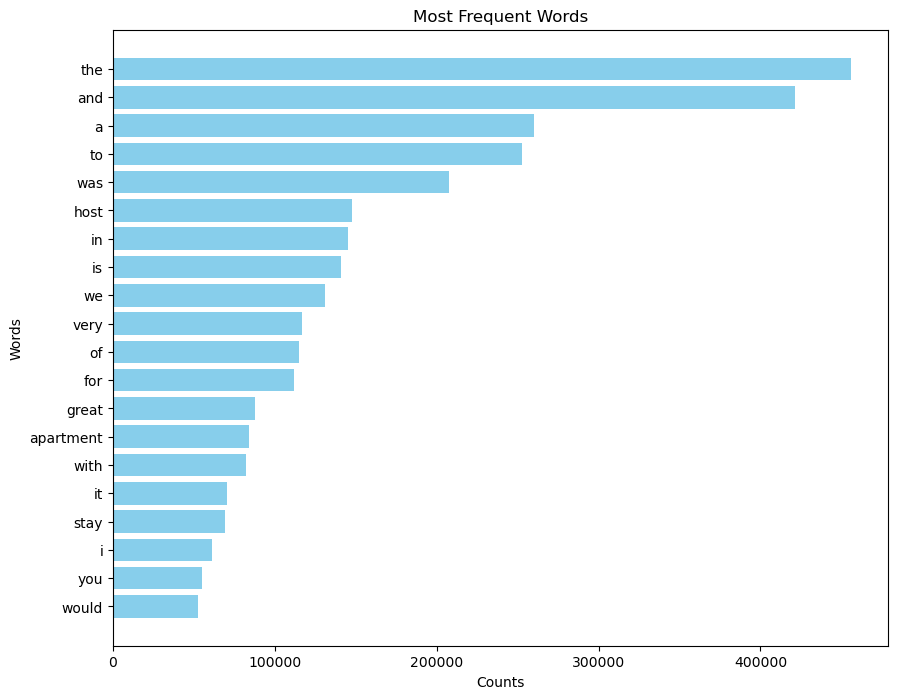

In [75]:
from collections import Counter

# Concatenate all comments into a single string
all_comments = ' '.join(df['comments'])

# Split the string into individual words
word_list = all_comments.split()

# Count the frequency of each word
word_freq = Counter(word_list)

# Get the most common words and their counts
most_common_words = word_freq.most_common(20)  # Adjust the number as needed
words, counts = zip(*most_common_words)  # Unzip the list of tuples into two lists

# Create a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(words, counts, color='skyblue')
plt.xlabel('Counts')
plt.ylabel('Words')
plt.title('Most Frequent Words')
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest count at the top
plt.show()

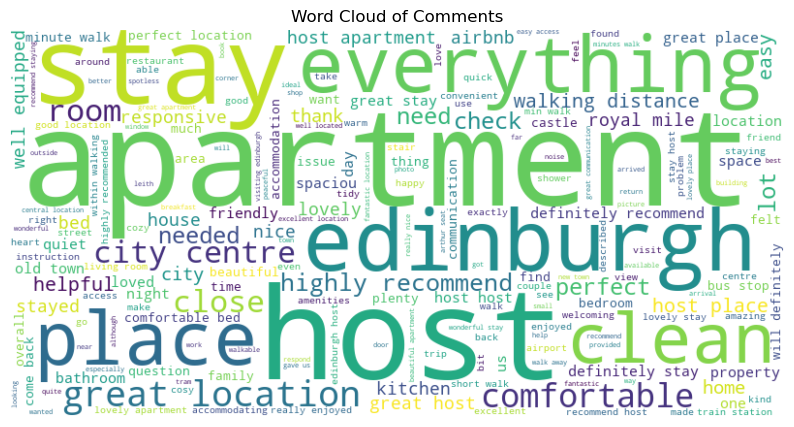

In [72]:
# Word Cloud of Comments - most frequent words in customer reviews
text = ' '.join(df['comments'].dropna())
wordcloud = WordCloud(width = 800, height = 400, background_color='white').generate(text)

plt.figure(figsize = (10,6))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Word Cloud of Comments')
plt.show()

In [73]:
df.head()

,listing_id,id,date,reviewer_id,comments,ReviewLenght,Year,Lang,host_name,neighbourhood_cleansed,...,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Number of Sentences,Number of Words,Number of Characters,Host,Host freq
0,15420,755523548,2021-06-05,187504576,a fantastic apartment which is beautifully fur...,324,2021,en,host_0,"Old Town, Princes Street and Leith Street",...,3,545,3.4,1,58,3,50,324,False,0
1,15420,761386255,2021-05-23,119596131,we had the most amazing stay at host's place. ...,332,2021,en,host_0,"Old Town, Princes Street and Leith Street",...,3,545,3.4,1,58,6,54,332,True,2
2,15420,770467244,2021-06-14,111721539,i booked host's apartment as a surprise for my...,450,2021,en,host_0,"Old Town, Princes Street and Leith Street",...,3,545,3.4,1,58,6,78,450,True,3
3,15420,396926559045081909,2021-01-07,41684971,i've stayed at host's place many times. so com...,206,2021,en,host_0,"Old Town, Princes Street and Leith Street",...,3,545,3.4,1,58,3,33,206,True,2
4,15420,398989660111676009,2021-04-07,357578834,such a fabulous apartment in a brilliant locat...,112,2021,en,host_0,"Old Town, Princes Street and Leith Street",...,3,545,3.4,1,58,2,19,112,True,1
